In [13]:
import torch
import os
from torch.utils.data import TensorDataset,ConcatDataset,DataLoader
import matplotlib.pyplot as plt
from torch import nn
from torch.nn.functional import relu
from tqdm import tqdm
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = 'cuda'
conditions = ['PF','Vehicle']
path_to_pt_ekyn = f'../pt_ekyn'
path_to_pt_snezana_mice = f'../pt_snezana_mice'

ekyn_ids = sorted(set([recording_filename.split('_')[0] for recording_filename in os.listdir(path_to_pt_ekyn)]))
snezana_mice_ids = sorted(set([recording_filename.split('.')[0] for recording_filename in os.listdir(path_to_pt_snezana_mice)]))
print(len(ekyn_ids),ekyn_ids)
print(len(snezana_mice_ids),snezana_mice_ids)

def load_ekyn(id,condition):
    X,y = torch.load(f'{path_to_pt_ekyn}/{id}_{condition}.pt',weights_only=False)
    return X,y
def load_snezana_mice(id):
    X,y = torch.load(f'{path_to_pt_snezana_mice}/{id}.pt',weights_only=False)
    return X,y

class EEGPairDataset(torch.utils.data.Dataset):
    def __init__(self, id, condition):
        self.X,self.y = load_ekyn(id=id,condition=condition)
        mean = self.X.flatten().mean()
        std = self.X.flatten().std()
        self.X = (self.X - mean) / (std + 1e-5)
        self.X = self.X[:,::10]
        self.X = self.X.unsqueeze(1)

    def __len__(self):
        return len(self.X) - 1

    def __getitem__(self, idx):
        x_t = self.X[idx]
        x_t1 = self.X[idx+1]
        return x_t,x_t1

class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, id, condition):
        self.X,self.y = load_ekyn(id=id,condition=condition)
        mean = self.X.flatten().mean()
        std = self.X.flatten().std()
        self.X = (self.X - mean) / (std + 1e-5)
        self.X = self.X[:,::10]
        self.X = self.X.unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx],self.y[idx]
    
# Encoder: CNN to map EEG epoch to 128-D embedding
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=15, stride=2, padding=7)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=15, stride=2, padding=7)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=15, stride=2, padding=7)
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.squeeze(-1)  # Shape: (batch_size, 128)
        return x

# Predictor: MLP to predict next embedding
class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 128)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# JEPA Model: Combines encoder and predictor
class JEPAModel(nn.Module):
    def __init__(self):
        super(JEPAModel, self).__init__()
        self.encoder = Encoder()
        self.predictor = Predictor()

    def forward(self, x_t):
        z_t = self.encoder(x_t)
        hat_z_t1 = self.predictor(z_t)
        return hat_z_t1
    


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = JEPAModel()
optimizer = torch.optim.AdamW(model.parameters(),lr=3e-4)
criterion = nn.MSELoss()

print(device)

16 ['A1-0', 'A1-1', 'A4-0', 'B1-0', 'B3-1', 'C1-0', 'C4-0', 'C4-1', 'D1-0', 'E1-0', 'E2-1', 'E4-0', 'E4-1', 'F1-0', 'F1-1', 'F5-1']
58 ['21-HET-1', '21-HET-10', '21-HET-11', '21-HET-12', '21-HET-13', '21-HET-2', '21-HET-3', '21-HET-4', '21-HET-5', '21-HET-7', '21-HET-8', '21-HET-9', '21-KO-1', '21-KO-10', '21-KO-11', '21-KO-12', '21-KO-2', '21-KO-3', '21-KO-4', '21-KO-5', '21-KO-6', '21-KO-7', '21-KO-8', '21-KO-9', '21-WK-1', '21-WK-10', '21-WK-11', '21-WK-12', '21-WK-13', '21-WK-15', '21-WK-16', '21-WK-17', '21-WK-18', '21-WK-2', '21-WK-3', '21-WK-4', '21-WK-5', '21-WK-6', '21-WK-8', '21-WK-9', '21-WT-1', '21-WT-10', '21-WT-12', '21-WT-13', '21-WT-2', '21-WT-3', '21-WT-4', '21-WT-5', '21-WT-6', '21-WT-7', '21-WT-8', '21-WT-9', '354', '378', '381', '382', '386', '429']
cuda


In [14]:
train_ids = ekyn_ids[:8]
test_ids = ekyn_ids[8:]
trainloader = DataLoader(ConcatDataset([EEGPairDataset(id=id,condition='PF') for id in train_ids]), batch_size=512, shuffle=True)
testloader = DataLoader(ConcatDataset([EEGPairDataset(id=id,condition='PF') for id in test_ids]), batch_size=512, shuffle=True)

In [17]:
model.to(device)
model.train()
n_epochs = 1000
lossi = []

for epoch in range(n_epochs):
    total_loss = 0
    for x_t, x_t1 in trainloader:
        x_t, x_t1 = x_t.to(device), x_t1.to(device)

        # Compute embeddings
        z_t = model.encoder(x_t)
        z_t1 = model.encoder(x_t1).detach()  # Detach target

        # Predict next embedding
        hat_z_t1 = model.predictor(z_t)

        # Assume hat_z_t1 and z_t1 are tensors of shape (batch_size, embedding_dim)
        batch_size = hat_z_t1.size(0)
        tau = 0.1  # Temperature parameter

        # Normalize embeddings
        hat_z_t1_norm = F.normalize(hat_z_t1, dim=1)
        z_t1_norm = F.normalize(z_t1, dim=1)

        # Compute similarity matrix (B x B)
        sim_matrix = torch.mm(hat_z_t1_norm, z_t1_norm.t()) / tau

        # Labels: diagonal elements are the positives
        labels = torch.arange(batch_size).to(hat_z_t1.device)

        # Compute InfoNCE loss
        loss = F.cross_entropy(sim_matrix, labels)
        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        lossi.append(loss.item())
    plt.figure()
    plt.plot(lossi)
    plt.savefig('loss.jpg')
    plt.close()
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {total_loss / len(trainloader):.4f}")


Epoch [1/1000], Loss: 3.9480
Epoch [2/1000], Loss: 3.9420
Epoch [3/1000], Loss: 3.9480
Epoch [4/1000], Loss: 3.9439
Epoch [5/1000], Loss: 3.9437
Epoch [6/1000], Loss: 3.9404
Epoch [7/1000], Loss: 3.9375
Epoch [8/1000], Loss: 3.9444
Epoch [9/1000], Loss: 3.9442
Epoch [10/1000], Loss: 3.9450
Epoch [11/1000], Loss: 3.9415
Epoch [12/1000], Loss: 3.9436
Epoch [13/1000], Loss: 3.9351
Epoch [14/1000], Loss: 3.9392
Epoch [15/1000], Loss: 3.9424
Epoch [16/1000], Loss: 3.9395
Epoch [17/1000], Loss: 3.9374
Epoch [18/1000], Loss: 3.9375
Epoch [19/1000], Loss: 3.9395
Epoch [20/1000], Loss: 3.9345
Epoch [21/1000], Loss: 3.9333
Epoch [22/1000], Loss: 3.9381
Epoch [23/1000], Loss: 3.9383
Epoch [24/1000], Loss: 3.9366
Epoch [25/1000], Loss: 3.9358
Epoch [26/1000], Loss: 3.9381
Epoch [27/1000], Loss: 3.9354
Epoch [28/1000], Loss: 3.9376
Epoch [29/1000], Loss: 3.9353
Epoch [30/1000], Loss: 3.9406
Epoch [31/1000], Loss: 3.9310
Epoch [32/1000], Loss: 3.9348
Epoch [33/1000], Loss: 3.9393
Epoch [34/1000], Lo

KeyboardInterrupt: 

In [18]:
trainloader = DataLoader(ConcatDataset([EEGDataset(id=id,condition='PF') for id in train_ids]), batch_size=512, shuffle=True)
testloader = DataLoader(ConcatDataset([EEGDataset(id=id,condition='PF') for id in test_ids]), batch_size=512, shuffle=True)

<Axes: xlabel='0', ylabel='1'>

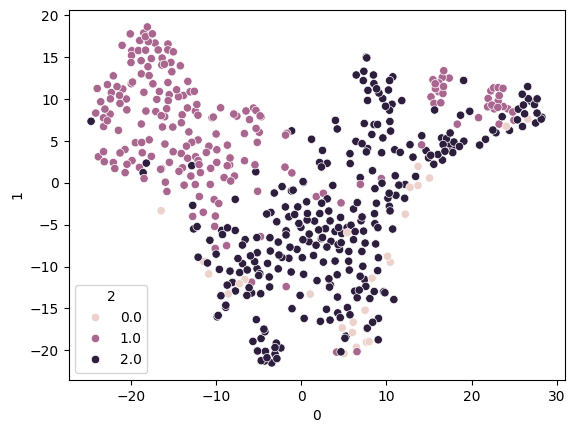

In [21]:
from sklearn.manifold import TSNE
import pandas as pd
tsne = TSNE()

model.eval()
Xi,yi = next(iter(trainloader))
Xi,yi = Xi.to(device),yi.to(device)
with torch.no_grad():
    embeddings = model.encoder(Xi).cpu()
Xi_tsne = tsne.fit_transform(embeddings)
df = pd.DataFrame(torch.hstack([torch.from_numpy(Xi_tsne),yi.cpu().argmax(dim=1,keepdim=True)]))
sns.scatterplot(data=df,x=0,y=1,hue=2)

In [22]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = model.encoder
        for p in self.encoder.parameters():
            p.requires_grad = False
        self.fc1 = nn.Linear(128, 32)
        self.fc2 = nn.Linear(32, 3)
    def forward(self, x):
        x = self.encoder(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
criterion = nn.CrossEntropyLoss()
classifier = Classifier()
optimizer = torch.optim.AdamW(classifier.parameters(),lr=3e-4)

In [24]:
for p in classifier.encoder.parameters():
    p.requires_grad = True

In [25]:
from lib.utils import calculate_f1,plot_training_progress
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score
import numpy as np

import torch
from torch import nn

from lib.utils import get_dataloader
from lib.utils import SleepStageClassifier
from lib.utils import ekyn_ids,snezana_mice_ids,courtney_ids
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
from lib.utils import calculate_f1,plot_training_progress

validation_frequency_epochs = 1
best_dev_loss = torch.inf
best_dev_loss_epoch = 0
best_dev_f1 = 0
best_dev_f1_epoch = 0
ma_window_size = 10

classifier.to(device)
classifier.train()

trainlossi = []
testlossi = []
train_f1s = []
test_f1s = []

pbar = tqdm(range(1000))
for epoch in pbar:
    epoch_train_f1s = []  # Collect F1s for each batch in this epoch
    epoch_train_losses = []  # Collect losses for each batch in this epoch
    
    for Xi, yi in trainloader:
        Xi, yi = Xi.to(device), yi.to(device)    
        logits = classifier(Xi)
        optimizer.zero_grad()
        loss = criterion(logits, yi)
        loss.backward()
        optimizer.step()
        
        # Calculate and store F1 for this batch
        batch_f1 = calculate_f1(logits, yi)
        epoch_train_f1s.append(batch_f1)
        epoch_train_losses.append(loss.item())
    
    # Add average loss and F1 for this epoch
    trainlossi.extend(epoch_train_losses)
    train_f1s.append(np.mean(epoch_train_f1s))
    
    if epoch % validation_frequency_epochs == 0:
        classifier.eval()
        all_test_preds = []
        all_test_labels = []
        test_losses = []

        with torch.no_grad():
            for Xi, yi in testloader:
                Xi, yi = Xi.to(device), yi.to(device)
                logits = classifier(Xi)
                loss = criterion(logits, yi)
                test_losses.append(loss.item())
                all_test_preds.append(logits.argmax(dim=1))
                all_test_labels.append(yi.argmax(dim=1))
            all_test_preds = torch.cat(all_test_preds).cpu()
            all_test_labels = torch.cat(all_test_labels).cpu()
            avg_test_loss = np.mean(test_losses)
            test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')

            testlossi.append(avg_test_loss)
            test_f1s.append(test_f1)

            # Call the updated plotting function with both loss and F1 data
            plot_training_progress(
                trainlossi,
                testlossi,
                train_f1s,
                test_f1s,
                ma_window_size,
                'training_metrics.jpg'
            )
            pbar.set_description(f"Train F1: {train_f1s[-1]:.4f}, Test F1: {test_f1:.4f}")

Train F1: 0.9473, Test F1: 0.7740:   3%|▎         | 28/1000 [01:02<36:24,  2.25s/it]


KeyboardInterrupt: 

In [ ]:
yi.shaope

In [ ]:
classifier.to(device)
model.to(device)
model.eval()
classifier.train()
lossi = []
for epoch in tqdm(range(200)):
    for Xi,yi in trainloader:
        Xi,yi = Xi.to(device),yi.to(device)
        latents = model.encoder(Xi)
        logits = classifier(latents)
        optimizer.zero_grad()
        loss = criterion(logits,yi)
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())

In [ ]:
plt.plot(lossi)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

y = torch.vstack([torch.vstack([classifier(model.encoder(Xi.to(device))).softmax(dim=1).argmax(dim=1).detach().cpu(),yi.argmax(dim=1).detach().cpu()]).T for Xi,yi in trainloader])
y_pred = y[:,0]
y_true = y[:,1]
print(classification_report(y_true=y_true,y_pred=y_pred))
ConfusionMatrixDisplay.from_predictions(y_true,y_pred)


y = torch.vstack([torch.vstack([classifier(model.encoder(Xi.to(device))).softmax(dim=1).argmax(dim=1).detach().cpu(),yi.argmax(dim=1).detach().cpu()]).T for Xi,yi in testloader])
y_pred = y[:,0]
y_true = y[:,1]
print(classification_report(y_true=y_true,y_pred=y_pred))
ConfusionMatrixDisplay.from_predictions(y_true,y_pred)

In [ ]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, noise_dim, output_channels=64, output_time_steps=1250):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.output_channels = output_channels
        self.output_time_steps = output_time_steps
        
        # Define the MLP layers
        self.fc1 = nn.Linear(noise_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, output_channels * output_time_steps)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Input: [batch_size, noise_dim]
        x = torch.relu(self.fc2(x))  # Hidden layers
        x = self.fc3(x)              # Output: [batch_size, 64*1250]
        x = x.view(-1, self.output_channels, self.output_time_steps)  # Reshape to [batch_size, 64, 1250]
        return x


def compute_mmd(x, y, sigma=1.0):
    def gaussian_kernel(a, b, sigma):
        a_sq = torch.sum(a ** 2, dim=1).view(-1, 1)
        b_sq = torch.sum(b ** 2, dim=1).view(1, -1)
        return torch.exp(- (a_sq - 2 * torch.mm(a, b.t()) + b_sq) / (2 * sigma ** 2))

    k_xx = gaussian_kernel(x, x, sigma)
    k_yy = gaussian_kernel(y, y, sigma)
    k_xy = gaussian_kernel(x, y, sigma)

    mmd = k_xx.mean() + k_yy.mean() - 2 * k_xy.mean()
    return mmd

# Extract paradoxical latent vectors
def extract_paradoxical_latents(autoencoder, train_loader, device='cpu'):
    autoencoder.eval()  # Set to evaluation mode
    paradoxical_latents = []

    with torch.no_grad():  # Disable gradient computation
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            labels = labels.argmax(dim=1)
            # Filter paradoxical samples (label 0)
            paradoxical_mask = (labels == 0)
            if paradoxical_mask.sum() > 0:  # If there are any paradoxical samples in the batch
                paradoxical_data = data[paradoxical_mask]  # [num_paradoxical, 1, 128]
                latent = autoencoder.encoder(paradoxical_data)  # [num_paradoxical, 64, 32]
                paradoxical_latents.append(latent.cpu())  # Move to CPU to save GPU memory

    # Concatenate all latent vectors
    if paradoxical_latents:
        paradoxical_latents = torch.cat(paradoxical_latents, dim=0)  # [total_paradoxical, 64, 32]
    else:
        paradoxical_latents = torch.tensor([])  # Empty tensor if no paradoxical samples

    return paradoxical_latents

In [ ]:
noise_dim = 100  # Example noise dimension
generator = Generator(noise_dim=noise_dim)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)

In [ ]:
mmd_lossi = []
generator.to(device)
generator.train()

for i in range(20):
    paradoxical_latent = extract_paradoxical_latents(autoencoder, trainloader, device)

    noise = torch.randn(512, noise_dim,device=device)
    synthetic_latent = generator(noise).cpu()
    mmd_loss = compute_mmd(paradoxical_latent.flatten(1,2), synthetic_latent.flatten(1,2), sigma=1.0)
    gen_optimizer.zero_grad()
    mmd_loss.backward()
    gen_optimizer.step()
    mmd_lossi.append(mmd_loss.item())

In [ ]:
plt.plot(mmd_lossi)

In [ ]:
# Generate synthetic data
num_synthetic = 50  # Number of synthetic samples to generate
noise = torch.randn(num_synthetic, noise_dim, device=device)
synthetic_latent = generator(noise)  # [num_synthetic, 64, 1250]
synthetic_eeg = autoencoder.decoder(synthetic_latent)
plt.plot(synthetic_eeg[0].T.cpu().detach())

In [ ]:


def compute_mmd(source, target, kernel_sigma=1.0):
    """
    Compute MMD between source and target latent features using a Gaussian kernel.
    Args:
        source: Tensor of shape (batch_size, feature_dim), e.g., (32, 64)
        target: Tensor of shape (batch_size, feature_dim), e.g., (32, 64)
        kernel_sigma: Bandwidth of the Gaussian kernel
    Returns:
        MMD loss (scalar)
    """
    # Number of samples
    n_source = source.size(0)
    n_target = target.size(0)

    # Compute pairwise distances
    xx = torch.cdist(source, source, p=2) ** 2  # Source-Source distances
    yy = torch.cdist(target, target, p=2) ** 2  # Target-Target distances
    xy = torch.cdist(source, target, p=2) ** 2  # Source-Target distances

    # Gaussian kernel: exp(-distance^2 / sigma^2)
    scale = 2 * (kernel_sigma ** 2)
    k_xx = torch.exp(-xx / scale)
    k_yy = torch.exp(-yy / scale)
    k_xy = torch.exp(-xy / scale)

    # MMD: mean of kernel terms
    mmd = k_xx.mean() + k_yy.mean() - 2 * k_xy.mean()
    return mmd

